# Analyze Data

In [1]:
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import FermionicMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

from qiskit.opflow import (I, X, Y, Z, Zero, One, MatrixEvolution, PauliTrotterEvolution, Suzuki,
                           StateFn, Zero, One, PauliExpectation, PauliOp, SummedOp, OperatorBase)

from qiskit.circuit import Parameter

import scipy.linalg as lng
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

## Import the Data

In [3]:
m_range = [-1.5,-1.3,-1.1,-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5]
y_range = [-1.5,-1.3,-1.1,-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5]


w = []
d = []
z = []
for m_set in m_range:
    w_y = []
    d_y = []
    z_y = []
    for y_set in y_range:
        w_y.append(np.load('../data/w_N_2_c_0.3_dt_0.7_t_5.0_w0_-3.5_dw_0.14_m_'+str(m_set)+'_x_1.5_y_'+str(y_set)+'_z_0.4.npy') )
        d_y.append(np.load('../data/decoder_N_2_c_0.3_dt_0.7_t_5.0_w0_-3.5_dw_0.14_m_'+str(m_set)+'_x_1.5_y_'+str(y_set)+'_z_0.4.npy') )
        z_y.append(np.load('../data/SE_1trot_N_2_c_0.3_dt_0.7_t_5.0_w0_-3.5_dw_0.14_m_'+str(m_set)+'_x_1.5_y_'+str(y_set)+'_z_0.4.npy') )
    w.append(w_y)
    d.append(d_y)
    z.append(z_y)

## Do the classical simulation using eigenvalues

In [4]:
hm = sum(FermionicOp(label) for label in ['IN', 'NI'])
ht = FermionicOp('+-') - FermionicOp('-+')
hD = FermionicOp('++') - FermionicOp('--')
hU = sum(FermionicOp(label) for label in ['NN'])

mapper = JordanWignerMapper()
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)

mu = Parameter('μ')
TT = Parameter('T')
DD = Parameter('Δ')
UU = Parameter('U')

hm_pauli = mu*(converter.convert(hm))
ht_pauli = TT*(converter.convert(ht))
hD_pauli = DD*(converter.convert(hD))
hU_pauli = UU*(converter.convert(hU))

ham_pauli = hm_pauli + ht_pauli  + hD_pauli + hU_pauli

<ipython-input-4-ffd6f697b8a7>:1: UserWarning: The default value for `display_format` will be changed from 'dense' to 'sparse' in version 0.3.0. Once that happens, you must specify display_format='dense' directly.
  hm = sum(FermionicOp(label) for label in ['IN', 'NI'])


In [5]:
y_a = []
m_a = []
de_a = []
for m_i in range(0,16):
    y_l = []
    m_l = []
    err_l = []
    de_l = []
    ded_l = []
    for y_i in range(0,16):
        # direct diagonalization of the Pauli Hamiltonian
        m_set = m_range[m_i]
        x_set = 1.5
        y_set = y_range[y_i]
        z_set = -0.4
        T_set = x_set + y_set
        D_set = x_set - y_set
        U_set = 4*z_set
        mu_set = -2*(m_set + z_set)
        param_bind = {TT: T_set, DD: D_set, UU: U_set, mu: mu_set}
        evalues, evects = lng.eig(ham_pauli.bind_parameters(param_bind).to_matrix())
        evalues = np.sort(evalues)
        DE = evalues[1]-evalues[0]
        y_l.append(y_i)
        m_l.append(m_i)
        de_l.append(DE)
    y_a.append(y_l)
    m_a.append(m_l)
    de_a.append(de_l)



Text(33.0, 0.5, 'm')

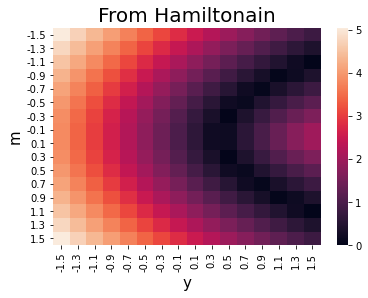

In [6]:
# Create a dataset
df = pd.DataFrame(np.array(np.real(de_a)),columns=y_range, index = m_range)

# Default heatmap
p1 = sns.heatmap(df)
plt.title('From Hamiltonain', fontsize = 20) # title with fontsize 20
plt.xlabel('y', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('m', fontsize = 15) # y-axis label with fontsize 15

## Find the energy transistions from the data

In [7]:
#Calculates the average derivative of the data of a range l
def avg_div(zl,wl,l):
    L = len(wl)
    dzdw_l = []
    w2_l = []
    for i in range(L-2*l):
        z1_avg = 0
        z2_avg = 0
        for a in range(l):
            z1_avg += zl[i+a]
            z2_avg += zl[i+a+l]
        dz = z2_avg - z1_avg
        dw = wl[i+l]-wl[i]
        dzdw = dz/dw
        dzdw_l.append(dzdw)
        w2_l.append((wl[i+2*l]+wl[i])/2)
    return dzdw_l,w2_l
    

In [8]:
# finds the zeros of the derivative of the data
def find_zeros(dz,w2,offset):
    zeros = []
    fake = 1
    for i in range(len(dz)-1):
        if (dz[i]+offset)*(dz[i+1]+offset) < 0: 
            fake = np.mod(fake+1,2)
            if fake == 0:
                zeros.append((w2[i+1]+w2[i])/2)
    return zeros 

In [9]:
#Finds minimums and sorts them into the first and second enegy transistions
offset = 0.0
E1 = []
E2 = []
Ly = len(y_range)
Lm = len(m_range)
for mi in range(Ly):
    E1_y = []
    E2_y = []
    for yi in range(Lm):
        zl = z[mi][yi]
        wl = w[mi][yi]
        dz,w2 = avg_div(zl,wl,4)
        zeros = find_zeros(dz,w2,offset)
        if len(zeros) == 2:
            E1_z = np.abs(zeros[0])
            E2_z = np.abs(zeros[1])
        elif len(zeros) == 1:
            E1_z = np.abs(zeros[0])
            E2_z = 3
        else:
            E1_z = 3
            E2_z = 3
        #print(mi,yi,zeros,[E1_z,E2_z])
        E1_y.append(E1_z)
        E2_y.append(E2_z)
    E1.append(E1_y)
    E2.append(E2_y)
    
#Finds the best value between +m and -m
mL = len(m_range)
yL = len(y_range)
E1_sym = copy.deepcopy(E1)
for mi in range(int(mL/2)):
    for yi in range(yL):
        E1_sym[mi][yi] = min(E1[mi][yi],E1[mL-mi-1][yi])
        E1_sym[mL-mi-1][yi] = min(E1[mi][yi],E1[mL-mi-1][yi])

#Cuts off the negetive y values        
mL = len(m_range)
yL = len(y_range)
E1_half = []
de_half = []
for mi in range(0,mL):
    E1_half_m = []
    de_half_m = []
    for yi in range(int(yL/2),yL):
        E1_half_m.append(E1_sym[mi][yi])
        de_half_m.append(de_a[mi][yi])
    E1_half.append(E1_half_m)
    de_half.append(de_half_m)
y_range_half = y_range[int(yL/2):yL]

Text(33.0, 0.5, 'm')

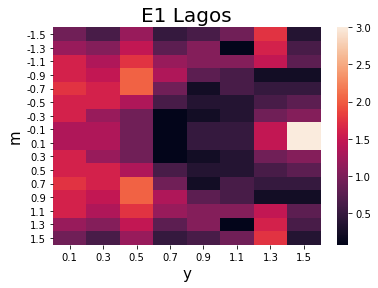

In [10]:
# Create a dataset
df = pd.DataFrame(np.array(E1_half),columns=y_range_half, index = m_range)

# Default heatmap
p1 = sns.heatmap(df)
plt.title('E1 Lagos', fontsize = 20) # title with fontsize 20
plt.xlabel('y', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('m', fontsize = 15) # y-axis label with fontsize 15

Text(33.0, 0.5, 'm')

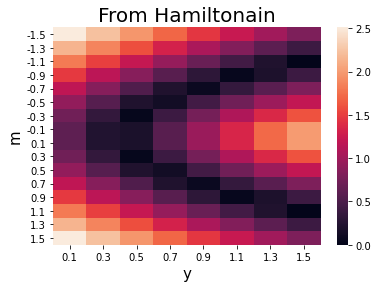

In [11]:
# Create a dataset
df = pd.DataFrame(np.array(np.real(de_half)),columns=y_range_half, index = m_range)

# Default heatmap
p1 = sns.heatmap(df)
plt.title('From Hamiltonain', fontsize = 20) # title with fontsize 20
plt.xlabel('y', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('m', fontsize = 15) # y-axis label with fontsize 15

<ipython-input-12-c684fbf50a18>:6: RuntimeWarning: invalid value encountered in sqrt
  data2 = [shift+np.sqrt(zp**2 + zp*(x + y) + x*y) for y in y_range_line]
<ipython-input-12-c684fbf50a18>:7: RuntimeWarning: invalid value encountered in sqrt
  data3 = [shift-np.sqrt(zp**2 + zp*(x + y) + x*y) for y in y_range_line]


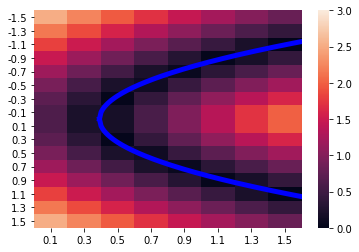

In [12]:
adj = 4.9
shift = 8
zp = (z_set)*adj
x = x_set*adj
y_range_line = [0.01*yi*adj for yi in range(200)]
data2 = [shift+np.sqrt(zp**2 + zp*(x + y) + x*y) for y in y_range_line]
data3 = [shift-np.sqrt(zp**2 + zp*(x + y) + x*y) for y in y_range_line]

plt.plot(y_range_line,data2,color = 'blue', linewidth = 5)
plt.plot(y_range_line,data3, color = 'blue', linewidth = 5)
p1 = sns.heatmap(df,vmax=3.0)

## Upload classical algorithm simulation data 

In [13]:
import numpy as np
from qiskit.circuit import Parameter
import scipy.linalg as lng
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Trotterize that Unitary
dt = 0.7  #[1.2,0.8,0.7,0.6,0.5]
tf = 5.0
trot_steps = int(tf/dt)
#trot_op_1 = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=trot_steps)).convert(evo_and_obsv)

# parameters
w0 = 3.5
dw = 0.14
c_set = 0.3 #[0.3 for all ,0.1 for t = 0.7]
x_set = 1.5
z_set = 0.4 #[0.0 for c = 0.3 and dt = 1.2, 0.4 for all]
t_set = tf
dt_set = dt


mu = Parameter('μ')
TT = Parameter('T')
DD = Parameter('Δ')
UU = Parameter('U')

m_range = [-1.5,-1.3,-1.1,-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5]
y_range = [-1.5,-1.3,-1.1,-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5]
w_range = np.linspace(-w0, w0, int(2*w0/dw))

In [14]:
PTL = []
for m_i in range(0,16):
    PTL_m = []
    for y_i in range(0,16):
        m_set = m_range[m_i]
        y_set = y_range[y_i]
        PTL_ym = np.load('../data/SIM_trot_N_2_c_'+str(c_set)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set)+'.npy')
        PTL_m.append(PTL_ym)
    PTL.append(PTL_m)

In [15]:
#Finds minimums and sorts them into the first and second enegy transistions
y_a = []
m_a = []
deT_a = []
E1s = []
for m_i in range(0,16):
    y_l = []
    m_l = []
    deT_l = []
    E1s_l = []
    for y_i in range(0,16):
        m_set = m_range[m_i]
        y_set = y_range[y_i]
        i_minT = np.argmin(PTL[m_i][y_i])
        
        zl = PTL[m_i][y_i]
        wl = w_range
        dz,w2 = avg_div(zl,wl,7)
        zeros = find_zeros(dz,w2,offset)        
        E1s_y = zeros[0]
        DET = w_range[i_minT]
        
        #print(m_i,y_i,w_range[i_minT],zeros)
        #print(m_i,y_i,DET,E1_y)
        y_l.append(y_i)
        m_l.append(m_i)
        deT_l.append(np.abs(DET))
        E1s_l.append(np.abs(DET))
    y_a.append(y_l)
    m_a.append(m_l)
    deT_a.append(deT_l)
    E1s.append(E1s_l)


    
#Finds the best value between +m and -m
mL = len(m_range)
yL = len(y_range)
E1s_sym = copy.deepcopy(E1s)
for mi in range(int(mL/2)):
    for yi in range(yL):
        E1s_sym[mi][yi] = min(E1s[mi][yi],E1s[mL-mi-1][yi])
        E1s_sym[mL-mi-1][yi] = min(E1s[mi][yi],E1s[mL-mi-1][yi])

#Cuts off the negetive y values        
mL = len(m_range)
yL = len(y_range)
E1s_half = []
for mi in range(0,mL):
    E1s_half_m = []
    for yi in range(int(yL/2),yL):
        E1s_half_m.append(E1s_sym[mi][yi])
    E1s_half.append(E1s_half_m)
y_range_half = y_range[int(yL/2):yL]

Text(33.0, 0.5, 'm')

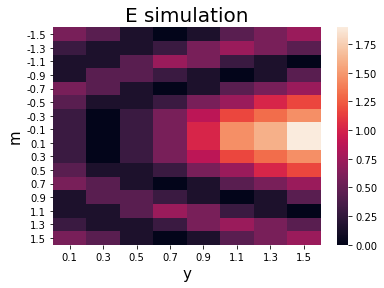

In [16]:
# Create a dataset
df = pd.DataFrame(np.array(E1s_half),columns=y_range_half, index = m_range)

# Default heatmap
p1 = sns.heatmap(df)
plt.title('E simulation', fontsize = 20) # title with fontsize 20
plt.xlabel('y', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('m', fontsize = 15) # y-axis label with fontsize 15

<ipython-input-17-b37a8b5642f2>:6: RuntimeWarning: invalid value encountered in sqrt
  data2 = [shift+np.sqrt(zp**2 + zp*(x + y) + x*y) for y in y_range_line]
<ipython-input-17-b37a8b5642f2>:7: RuntimeWarning: invalid value encountered in sqrt
  data3 = [shift-np.sqrt(zp**2 + zp*(x + y) + x*y) for y in y_range_line]


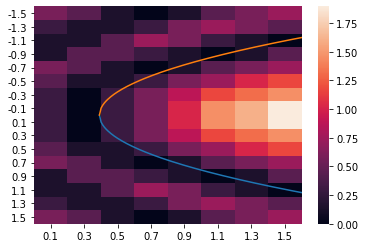

In [17]:
adj = 4.9
shift = 8
zp = -z_set*adj
x = x_set*adj
y_range_line = [0.01*yi*adj for yi in range(200)]
data2 = [shift+np.sqrt(zp**2 + zp*(x + y) + x*y) for y in y_range_line]
data3 = [shift-np.sqrt(zp**2 + zp*(x + y) + x*y) for y in y_range_line]

#plt.xlim(0,1.5)
#plt.ylim(-1.5,1.5)
plt.plot(y_range_line,data2)
plt.plot(y_range_line,data3)
p1 = sns.heatmap(df)

Text(33.0, 0.5, 'm')

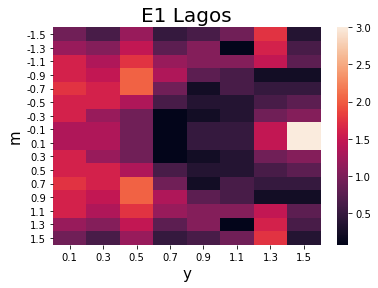

In [18]:
# Create a dataset
df = pd.DataFrame(np.array(E1_half),columns=y_range_half, index = m_range)

# Default heatmap
p1 = sns.heatmap(df)
plt.title('E1 Lagos', fontsize = 20) # title with fontsize 20
plt.xlabel('y', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('m', fontsize = 15) # y-axis label with fontsize 15

<ipython-input-19-682d29ed08e3>:6: RuntimeWarning: invalid value encountered in sqrt
  data2 = [shift+np.sqrt(zp**2 + zp*(x + y) + x*y) for y in y_range_line]
<ipython-input-19-682d29ed08e3>:7: RuntimeWarning: invalid value encountered in sqrt
  data3 = [shift-np.sqrt(zp**2 + zp*(x + y) + x*y) for y in y_range_line]
<ipython-input-19-682d29ed08e3>:12: RuntimeWarning: invalid value encountered in sqrt
  data4 = [shift+np.sqrt(zp**2 + zp*(x + y) + x*y) for y in y_range_line]
<ipython-input-19-682d29ed08e3>:13: RuntimeWarning: invalid value encountered in sqrt
  data5 = [shift-np.sqrt(zp**2 + zp*(x + y) + x*y) for y in y_range_line]


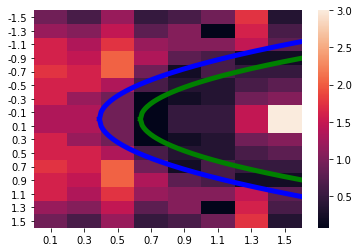

In [19]:
adj = 4.9
shift = 8
zp = (-z_set)*adj
x = x_set*adj
y_range_line = [0.01*yi*adj for yi in range(200)]
data2 = [shift+np.sqrt(zp**2 + zp*(x + y) + x*y) for y in y_range_line]
data3 = [shift-np.sqrt(zp**2 + zp*(x + y) + x*y) for y in y_range_line]

zp = (-z_set-0.25)*adj
x = x_set*adj
y_range_line = [0.01*yi*adj for yi in range(200)]
data4 = [shift+np.sqrt(zp**2 + zp*(x + y) + x*y) for y in y_range_line]
data5 = [shift-np.sqrt(zp**2 + zp*(x + y) + x*y) for y in y_range_line]

#plt.xlim(0,1.5)
#plt.ylim(-1.5,1.5)
plt.plot(y_range_line,data2,color = 'blue',linewidth = 5)
plt.plot(y_range_line,data3, color = 'blue',linewidth = 5)
plt.plot(y_range_line,data4,color = 'green',linewidth = 5)
plt.plot(y_range_line,data5, color = 'green',linewidth = 5)
p1 = sns.heatmap(df)

<ipython-input-20-f08d431436ff>:6: RuntimeWarning: invalid value encountered in sqrt
  data2 = [shift+np.sqrt(zp**2 + zp*(x + y) + x*y) for y in y_range_line]
<ipython-input-20-f08d431436ff>:7: RuntimeWarning: invalid value encountered in sqrt
  data3 = [shift-np.sqrt(zp**2 + zp*(x + y) + x*y) for y in y_range_line]


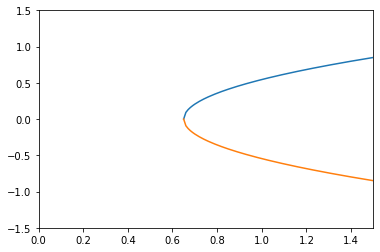

In [20]:
adj = 1
shift = 0
zp = (-z_set-0.25)*adj
x = x_set*adj
y_range_line = [0.01*yi*adj for yi in range(200)]
data2 = [shift+np.sqrt(zp**2 + zp*(x + y) + x*y) for y in y_range_line]
data3 = [shift-np.sqrt(zp**2 + zp*(x + y) + x*y) for y in y_range_line]

plt.xlim(0,1.5)
plt.ylim(-1.5,1.5)
plt.plot(y_range_line,data2)
plt.plot(y_range_line,data3)


## Fitting function

In [24]:
import scipy.optimize as optimization

def func(w, d1, S1,d2,S2,c):
    return 1-np.abs(c/(c**2+(d1+w)**2)*S1 + c/(c**2+(d2+w)**2)*S2)**2

mi = 7
yi = 7


d10 = 1.0
S10 = 0.2
d20 = -1.0
S20 = 0.2
c0 = c_set*4

#Function fitting
op =  optimization.curve_fit(func, w[mi][yi], z[mi][yi], p0 = [d10,S10,d20,S20,c0],maxfev = 50000, bounds = ([-5,0,-5,0,0],[5.0,2.0,5.0,2.0,10])) 

#Data Smoothing
dz,w2 = avg_div(z[mi][yi],w[mi][yi],4)
zeros = find_zeros(dz,w2,offset)


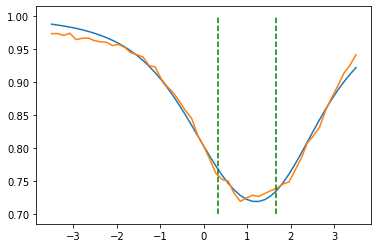

In [25]:
#Compare Data Smoothing to Function Fitting
d1 = op[0][0]
S1 = op[0][1]
d2 = op[0][2]
S2 = op[0][3]
c = op[0][4]
fit_data = [func(wi,d1,S1,d2,S2,c) for wi in w[0][0]]

plt.plot(w[mi][yi],fit_data)
plt.plot(w[mi][yi],z[mi][yi])
plt.plot(np.real([-op[0][0], -op[0][0]]), [0.7, 1], ls='--', color='green')
plt.plot(np.real([-op[0][2], -op[0][2]]), [0.7, 1], ls='--', color='green')
#plt.plot(np.real([zeros[0], zeros[0]]), [0.7, 1], ls='--', color='red')
#plt.plot(np.real([zeros[1], zeros[1]]), [0.7, 1], ls='--', color='red')

In [26]:
print(zeros)
op[0]

[1.1900000000000004]


array([-0.32304514,  0.49743449, -1.662155  ,  0.76902707,  2.19718146])

In [27]:
#Finds fits
d10 = 1.0
S10 = 0.2
d20 = -1.0
S20 = 0.2
c0 = c_set*4
E1 = []
E2 = []
Ly = len(y_range)
Lm = len(m_range)
for mi in range(Ly):
    E1_y = []
    E2_y = []
    for yi in range(Lm):
        zl = z[mi][yi]
        wl = w[mi][yi]
        op =  optimization.curve_fit(func, w[mi][yi], z[mi][yi], p0 = [d10,S10,d20,S20,c0],maxfev = 50000, bounds = ([-5,0,-5,0,0],[5.0,2.0,5.0,2.0,10]))         
        E1_z = abs(min([op[0][0],op[0][2]]))
        E2_z = abs(max([op[0][0],op[0][2]]))
        print(mi,yi,E1_z)
        E1_y.append(E1_z)
        E2_y.append(E2_z)
    E1.append(E1_y)
    E2.append(E2_y)

0 0 1.6895907112853747
0 1 0.8142375945962962
0 2 0.8062883841761912
0 3 0.6738270969115511
0 4 0.8550760854278934
0 5 0.5551845966598034
0 6 1.2263708095892014
0 7 1.7920203625621796
0 8 1.3862026921924764
0 9 1.3330369068900751
0 10 1.140870800782099
0 11 0.6912260902469292
0 12 1.1537412503084215
0 13 1.3442249028596913
0 14 1.1830239684216857
0 15 1.3263816838685296
1 0 1.354446715473395
1 1 0.870181802143589
1 2 0.8490934654606481
1 3 0.7463186704251613
1 4 0.9603060219930666
1 5 0.7503527684309683
1 6 0.9739347145500109
1 7 1.9267533767411538
1 8 1.4685106889277688
1 9 1.2931197100014653
1 10 1.419801740332381
1 11 1.098863749879886
1 12 1.7431533561262196
1 13 1.5821415753682782
1 14 1.409753909740858
1 15 1.586451165747201
2 0 1.38603342604594
2 1 0.6792112321035447
2 2 0.8854622755067101
2 3 0.7271922081754212
2 4 0.9652700723091833
2 5 0.9092960654296172
2 6 0.891921042962243
2 7 1.9204440698210743
2 8 1.571578093611945
2 9 1.4715222286198144
2 10 1.5275395283023339
2 11 1.35

In [28]:
E1

[[1.6895907112853747,
  0.8142375945962962,
  0.8062883841761912,
  0.6738270969115511,
  0.8550760854278934,
  0.5551845966598034,
  1.2263708095892014,
  1.7920203625621796,
  1.3862026921924764,
  1.3330369068900751,
  1.140870800782099,
  0.6912260902469292,
  1.1537412503084215,
  1.3442249028596913,
  1.1830239684216857,
  1.3263816838685296],
 [1.354446715473395,
  0.870181802143589,
  0.8490934654606481,
  0.7463186704251613,
  0.9603060219930666,
  0.7503527684309683,
  0.9739347145500109,
  1.9267533767411538,
  1.4685106889277688,
  1.2931197100014653,
  1.419801740332381,
  1.098863749879886,
  1.7431533561262196,
  1.5821415753682782,
  1.409753909740858,
  1.586451165747201],
 [1.38603342604594,
  0.6792112321035447,
  0.8854622755067101,
  0.7271922081754212,
  0.9652700723091833,
  0.9092960654296172,
  0.891921042962243,
  1.9204440698210743,
  1.571578093611945,
  1.4715222286198144,
  1.5275395283023339,
  1.3536319446771137,
  1.986287966970643,
  1.8505408599448472

Text(33.0, 0.5, 'm')

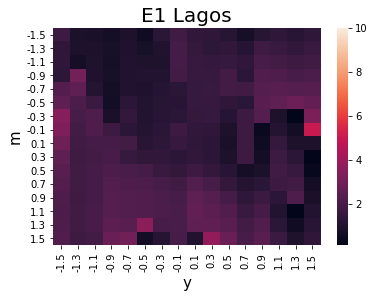

In [29]:
# Create a dataset
df = pd.DataFrame(np.array(E1),columns=y_range, index = m_range)

# Default heatmap
p1 = sns.heatmap(df,vmax = 10)
plt.title('E1 Lagos', fontsize = 20) # title with fontsize 20
plt.xlabel('y', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('m', fontsize = 15) # y-axis label with fontsize 15

In [30]:
#Finds the best value between +m and -m
mL = len(m_range)
yL = len(y_range)
E1s_sym = copy.deepcopy(E1s)
for mi in range(int(mL/2)):
    for yi in range(yL):
        E1s_sym[mi][yi] = min(E1[mi][yi],E1[mL-mi-1][yi])
        E1s_sym[mL-mi-1][yi] = min(E1[mi][yi],E1[mL-mi-1][yi])

#Cuts off the negetive y values        
mL = len(m_range)
yL = len(y_range)
E1s_half = []
for mi in range(0,mL):
    E1s_half_m = []
    for yi in range(int(yL/2),yL):
        E1s_half_m.append(E1s_sym[mi][yi])
    E1s_half.append(E1s_half_m)
y_range_half = y_range[int(yL/2):yL]

Text(33.0, 0.5, 'm')

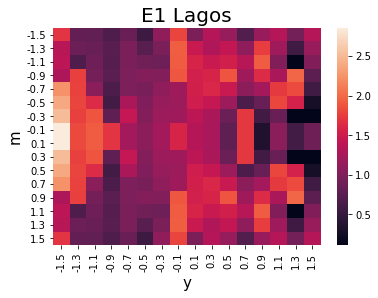

In [31]:
# Create a dataset
df = pd.DataFrame(np.array(E1s_sym),columns=y_range, index = m_range)

# Default heatmap
p1 = sns.heatmap(df)
plt.title('E1 Lagos', fontsize = 20) # title with fontsize 20
plt.xlabel('y', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('m', fontsize = 15) # y-axis label with fontsize 15

Text(33.0, 0.5, 'm')

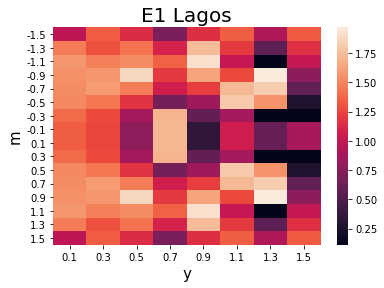

In [32]:
# Create a dataset
df = pd.DataFrame(np.array(E1s_half),columns=y_range_half, index = m_range)

# Default heatmap
p1 = sns.heatmap(df)
plt.title('E1 Lagos', fontsize = 20) # title with fontsize 20
plt.xlabel('y', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('m', fontsize = 15) # y-axis label with fontsize 15